# Data Exploration 
* 소개 
> \[ __JobCare 추천 알고리즘 경진대회__ \]에 참가하며 진행했던 __탐색 과정과 약간의 시각화 내용을__ 담아보았습니다. 


------------------------

## Import Libraries  

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

## Load Dataset

--------------------------------------

: 제공된 데이터를 불러옵니다. 

In [2]:
# Original dataset  
data_dir = '../data/JobCare_data/'

# path for Prediction.csv  
subm_dir = '../submission/'

In [3]:
train = pd.read_csv(data_dir+'train.csv')
test = pd.read_csv(data_dir+'test.csv')

# Feature codes 
feature_D_code = pd.read_csv(data_dir+'속성_D_코드.csv')
feature_H_code = pd.read_csv(data_dir+'속성_H_코드.csv')
feature_L_code = pd.read_csv(data_dir+'속성_L_코드.csv')

## Data handling  

--------------------------------------

: 본격적인 데이터 가공에 앞서, 편의를 위해 컬럼명, 데이터 타입을 간략히 수정하고 진행합니다. 

In [4]:
# Rename Columns
D_code_map = {
    '속성 D 코드': 'D_ALL', 
    '속성 D 세분류코드': 'D_DET', 
    '속성 D 소분류코드': 'D_SML', 
    '속성 D 중분류코드': 'D_MED', 
    '속성 D 대분류코드': 'D_LAG'
}

H_code_map = {
    '속성 H 코드': 'H_ALL', 
    '속성 H 중분류코드': 'H_MED', 
    '속성 H 대분류코드': 'H_LAG'
}

L_code_map = {
    '속성 L 코드': 'L_ALL', 
    '속성 L 세분류코드': 'L_DET', 
    '속성 L 소분류코드': 'L_SML', 
    '속성 L 중분류코드': 'L_MED', 
    '속성 L 대분류코드': 'L_LAG' 
}

feature_D_code.columns = feature_D_code.columns.map(D_code_map)
feature_H_code.columns = feature_H_code.columns.map(H_code_map)
feature_L_code.columns = feature_L_code.columns.map(L_code_map)

In [5]:
# feature_D_code
# feature_H_code
feature_L_code.head()
# train.head()
# test.head()

# : 컬럼명을 단순하게 변환 

,L_ALL,L_DET,L_SML,L_MED,L_LAG
0,1,1,1,1,2004
1,2,2,2,1,2004
2,3,3,2,1,2004
3,4,3,2,1,2004
4,5,5,2,1,2004


: '컨텐츠열람일시'를 datetime 형으로 변환합니다. 

In [6]:
# Datetime handling (str to dt)
train['contents_open_dt'] = pd.to_datetime(train['contents_open_dt'], format="%Y-%m-%d %H:%M:%S")
test['contents_open_dt'] = pd.to_datetime(test['contents_open_dt'], format="%Y-%m-%d %H:%M:%S")

#### *cf) Create Person/Contents-Master tables

: 제공된 train/test 데이터는, 각각의 'person'과 해당 'content'가 매핑되어있는 테이블입니다. 탐색과정에서 편의를 위해, 고유 'person'과 'contents' 각각 한 개의 마스터 테이블로 정규화합니다. 

In [7]:
# Create person & contents master tables
person_train = train[train.columns[train.columns.str.contains('person_')]]
contnt_train = train[train.columns[train.columns.str.contains('contents_')]]

# >>> (~person_train.duplicated()).sum() 
# 300,177    # -> same w/ nunique(person_rn) 
# >>> (~(contnt_train.drop('contents_open_dt', axis=1).duplicated())).sum()
# 283,393    # -> same w/ nunique(contents_rn) 

person_master = person_train.drop_duplicates(keep='first')
contnt_master = contnt_train.drop('contents_open_dt', axis=1).drop_duplicates(keep='first')

# Arrange columns' order 
person_master = pd.concat([person_master['person_rn'], person_master.loc[:, person_master.columns!='person_rn']], axis=1)
contnt_master = pd.concat([contnt_master['contents_rn'], contnt_master.loc[:, contnt_master.columns!='contents_rn']], axis=1)

## Simple Descriptive stats.  

--------------------------------------

* 엔티티(: person_rn, contents_rn)에 대한 탐색 

In [8]:
# Counts for entities, between Train and test 
for rn_feat in ['person_rn', 'contents_rn']:
    print(f"# ================== Entity '{rn_feat}' Consistency check ================== ")
    rn_num_trainO_testX = len(set(train[rn_feat].unique()) - set(test[rn_feat].unique()))
    rn_num_trainX_testO = len(set(test[rn_feat].unique()) - set(train[rn_feat].unique()))

    rn_nuniq_train = train[rn_feat].nunique() 
    rn_nuniq_test = test[rn_feat].nunique() 

    print(f" * The # of '{rn_feat}' in 'train' but not in 'test' : {rn_num_trainO_testX:9,} out of {rn_nuniq_train:9,} (: {rn_num_trainO_testX/rn_nuniq_train:.2%})")
    print(f" * The # of '{rn_feat}' in 'test' but not in 'train' : {rn_num_trainX_testO:9,} out of {rn_nuniq_test:9,} (: {rn_num_trainX_testO/rn_nuniq_test:.2%})")
    
    print("\n")

# ================== Entity 'person_rn' Consistency check ================== 
 * The # of 'person_rn' in 'train' but not in 'test' :   292,029 out of   300,177 (: 97.29%)
 * The # of 'person_rn' in 'test' but not in 'train' :    26,386 out of    34,534 (: 76.41%)


# ================== Entity 'contents_rn' Consistency check ================== 
 * The # of 'contents_rn' in 'train' but not in 'test' :   279,696 out of   283,359 (: 98.71%)
 * The # of 'contents_rn' in 'test' but not in 'train' :    27,826 out of    31,489 (: 88.37%)




1. "person_rn"에 대해서   
$\to$ Train-set 고유고객 300,177명 중, 292,029명(97.29%)이 Test-set에 없고,   
$\to$ Test-set 고유고객 34,534명 중, 26,386명(76.41%)이 Train-set에 없습니다.    
        (즉, "고유고객의 이전 기록"(ex: 어떤 유형의 컨텐츠를 주로 봤는지, 보통 얼마 만에 다시 방문하는지 등)에 기반한 추론이 불가)    
        
2. 마찬가지로, "contents_rn"에 대해서   
$\to$ Train-set 고유 컨텐츠 283,359개 중, 279,696개(98.71%)가 Test-set에 없고,   
$\to$ Test-set 고유 컨텐츠 31,489개 중, 27,826개(88.37%)가 Train-set에 없습니다.    
        (즉, "고유 컨텐츠의 이전 기록"(ex: 얼마나 인기있는 컨텐츠였는지 등)은 활용이 불가)

* **_고유 'Person' 또는 'Contents'의 '과거 이력 및 특성'에 기반한 파생변수는 사용이 불가합니다._**
> 추천 시스템\*을 설계하는데 고려할 수 있는 좋은 접근 중 하나는, '과거 행동에 따른 유형 정의'가 있을 수 있습니다. 하지만, 이번 경진대회에 제공된 train/test 데이터에서는, 주요 엔티티에 해당하는 'person'과 'contents'의 전체 records에 약 90%가 서로 공유되지 않습니다. 즉, 고유 엔티티의 이력 및 특성을 정의하는 파생변수 생성이 어렵습니다. 예컨데, train에서 특정 고객 A의 '이전 3개월 컨텐츠 열람 이력'을 기반으로 파생변수 등을 만들어 모형에 반영할 수 없는 것입니다. 

\* 추천 시스템에 대한 접근과 방법에 따라 다를 수 있습니다.   

* '컨텐츠열람일시'에 대한 제공 범위 

In [9]:
print(f" * Train-set 'contents_open_dt' Min(): {train['contents_open_dt'].min()},  Max():{train['contents_open_dt'].max()}")
print(f" *  test-set 'contents_open_dt' Min(): {test['contents_open_dt'].min()},  Max():{test['contents_open_dt'].max()}")

 * Train-set 'contents_open_dt' Min(): 2020-01-01 00:01:03,  Max():2020-11-30 23:59:56
 *  test-set 'contents_open_dt' Min(): 2020-12-01 00:00:07,  Max():2020-12-31 23:59:08


1. 학습 데이터는   : 2020년 01월 ~ 11월 (총 11개월)간의 records이고 
2. 테스트 데이터는 : 2020년 12월 (1 개월)간의 records가 담겨있는 것을 확인할 수 있습니다. 

* **_'컨텐츠열람일시' 컬럼은, 이번 경진대회 제공 속성 중 '유일하게 본래 의미를 알 수 있는' 속성입니다._**
> 나머지 모든 속성은 가명화 및 비식별화, 코드화 되어 제공되었기 때문에 '해당 속성이 원래 어떤 내용을 담는 데이터인가'를 파악하기 어려운 반면, '컨텐츠열람일시'는 각 'person'이 해당 'contents'에 접근한 시점을 정확히 알 수 있습니다. 이에, 구직 관련 서비스에 대한 추천 시스템 설계라는 주제와 연관된, '시점'과 관련된 아이디어를 얻을 수도 있을 것 같습니다. 

In [10]:
person_dt_min = train.groupby('person_rn')['contents_open_dt'].min().rename('contents_open_dt_min')
person_dt_max = train.groupby('person_rn')['contents_open_dt'].max().rename('contents_open_dt_max')
person_dt_MinMiax = pd.merge(person_dt_min, person_dt_max, left_index=True, right_index=True, how='outer')

contnt_dt_min = train.groupby('contents_rn')['contents_open_dt'].min().rename('contents_open_dt_min')
contnt_dt_max = train.groupby('contents_rn')['contents_open_dt'].max().rename('contents_open_dt_max')
contnt_dt_MinMiax = pd.merge(contnt_dt_min, contnt_dt_max, left_index=True, right_index=True, how='outer')

In [11]:
person_dt_MinMiax['ne_dt'] = person_dt_MinMiax.iloc[:,0]!=person_dt_MinMiax.iloc[:,1]
ne_cnt = person_dt_MinMiax['ne_dt'].sum()
print(f" * not equal: {ne_cnt}  ({ne_cnt/person_dt_MinMiax.shape[0]: .2%}) ")
# person_dt_MinMiax.head()

 * not equal: 105917  ( 35.28%) 


In [12]:
contnt_dt_MinMiax['ne_dt'] = contnt_dt_MinMiax.iloc[:,0]!=contnt_dt_MinMiax.iloc[:,1]
ne_cnt = contnt_dt_MinMiax['ne_dt'].sum()
print(f" * not equal: {ne_cnt}  ({ne_cnt/contnt_dt_MinMiax.shape[0]: .2%}) ")
# contnt_dt_MinMiax.head()

 * not equal: 114813  ( 40.52%) 


> * 덧붙여서, 고유 'person' 및 'contents'가 train-set 안에 2 records 이상 관측된 경우가, 50%가 안됩니다. 
    * (개인은 2건 이상 record를 갖는 경우가, 35% )
    * (컨텐츠도 2건 이상 record를 갖는 경우, 41% )   
        $\to$ 결국은, 기본적으로 entities의 history 로는 접근할 수가 없습니다.  

## Some EDA 

--------------------------------------

In [13]:
# * Copy DF for Data Wrangling 
train_dt = train.copy()

In [14]:
# * Plotting Function 
def countsWithRelativeRatio(cols_for_comparison, data=train_dt, caption=False): 
    
    """ 탐색하고자 하는 범주형 변수 list를 받아, 빈도 / 비율 에 대한 bar plot을 그립니다. """
    
    # * Default Caption 
    caption_txt = """
    * 1. 'TARGET_Y'(Blue) : 'target'=='1' / 'TARGET_N'(Orange) : 'target'=='0'
    * 2. (left) Class Frequencies for train-set, (right) targets' relative-ratio for each class
    """
    
    num_cols = len(cols_for_comparison) # go to each rows
    fig, axes = plt.subplots(num_cols, 2, figsize=(20, num_cols*5))

    for i, grouping_col in enumerate(cols_for_comparison):
        # GroupBy Instance for each Categorical feature 
        grouped = train_dt.groupby([grouping_col])['target'] # GroupBy 'target' labels(: {1, 0})

        # * get Counts-for-each-class with relative-ratio-for-target
        # ---------------------------------- 
        # A.) Counts: ['TARGET_Y': the # of '1'(Positive), 'TARGET_N': the # of '0'(Negative)] 
        open_dt_grouped_by_cls = pd.concat([grouped.sum().rename('TARGET_Y'), grouped.count().rename('CNT')], axis=1) 
        open_dt_grouped_by_cls['TARGET_N'] = open_dt_grouped_by_cls['CNT'] - open_dt_grouped_by_cls['TARGET_Y']

        # B.) Relative Ratio: ['RATIO_Y': % of '1'(Positive), 'RATIO_N': % of '0'(Negative)] 
        open_dt_grouped_by_cls['RATIO_Y'] = (open_dt_grouped_by_cls['TARGET_Y'] / open_dt_grouped_by_cls['CNT']) 
        open_dt_grouped_by_cls['RATIO_N'] = 1 - open_dt_grouped_by_cls['RATIO_Y']

        # * Visualization 
        # ---------------------------------- 
        # A.)  Counts bar-plot (: Left-sided)
        open_dt_grouped_by_cls[['TARGET_Y', 'TARGET_N']].plot.bar(stacked=True, rot=35, ax=axes[i, 0], xlabel=' ')
        axes[i, 0].set_title(f"{grouping_col}_Count") 

        for cls_i, item_ in enumerate(open_dt_grouped_by_cls.itertuples()):
            axes[i, 0].text(x=cls_i, y=(item_.TARGET_Y)*0.5, s=f"{item_.TARGET_Y:,}\n({item_.CNT})", horizontalalignment='center', rotation=45)

        # B.)  Ratio bar-plot  (: Right-sided)
        open_dt_grouped_by_cls[['RATIO_Y', 'RATIO_N']].plot.bar(stacked=True, rot=35, ax=axes[i, 1], xlabel=' ')
        axes[i, 1].set_title(f"{grouping_col}_Ratio") 
        axes[i, 1].axhline(y=0.5, color='red', linestyle='--') # Half-line 

        for cls_i, item_ in enumerate(open_dt_grouped_by_cls.itertuples()):
                axes[i, 1].text(x=cls_i, y=(item_.RATIO_Y)*0.5, s=f"{item_.RATIO_Y:.2%}", horizontalalignment='center', rotation=45)
                
    # * Additional Caption below the plot
    if caption:
        fig.text(.14, .1, caption_txt, ha='left', size='medium')
        
    fig.show()

### 1. '컨텐츠열람일시'에 대한 시간-구성요소별 열람비율 비교 

In [15]:
train_dt['open_dt_month'] = train_dt['contents_open_dt'].dt.month
train_dt['open_dt_day'] = train_dt['contents_open_dt'].dt.day
train_dt['open_dt_week'] = train_dt['contents_open_dt'].dt.week
train_dt['open_dt_weekday'] = train_dt['contents_open_dt'].dt.weekday
# train_dt['open_dt_day_name'] = train_dt['contents_open_dt'].dt.day_name().str[:3]
train_dt['open_dt_quarter'] = train_dt['contents_open_dt'].dt.quarter
train_dt['open_dt_hour'] = train_dt['contents_open_dt'].dt.hour
train_dt['open_dt_minute'] = train_dt['contents_open_dt'].dt.minute

| 컬럼명            | 설명  | 비고 |
|:------------------|:------|:-----|
|"open_dt_month"    | 'contents_open_dt'의 '월' 성분 값 | |
|"open_dt_day"      | 'contents_open_dt'의 '일자' 성분 값 | |
|"open_dt_week"     | 'contents_open_dt' 해당 일자의 연중'주차'(Week of year) 성분 값 | |
|"open_dt_weekday"  | 'contents_open_dt'의 '요일' 성분 값 |{0:월, 1:화,...6:일} |
|"open_dt_quarter"  | 'contents_open_dt' 해당 일자의 '4분기' 성분 값 |{1: 1분기, ... 4: 4분기} |
|"open_dt_hour"     | 'contents_open_dt'의 '시간' 성분 값 | |
|"open_dt_minute"   | 'contents_open_dt'의 '분' 성분 값 | |

> * _1. 'TARGET_Y'(파랑) : 'target'=='1' / 'TARGET_N'(주황) : 'target'=='0'인 경우에 해당_
> * _2. 좌측은 train-set에 해당 records에 대한 빈도(Freq.), 우측은 각 class에 대한 백분위 비율(ratio)에 해당_

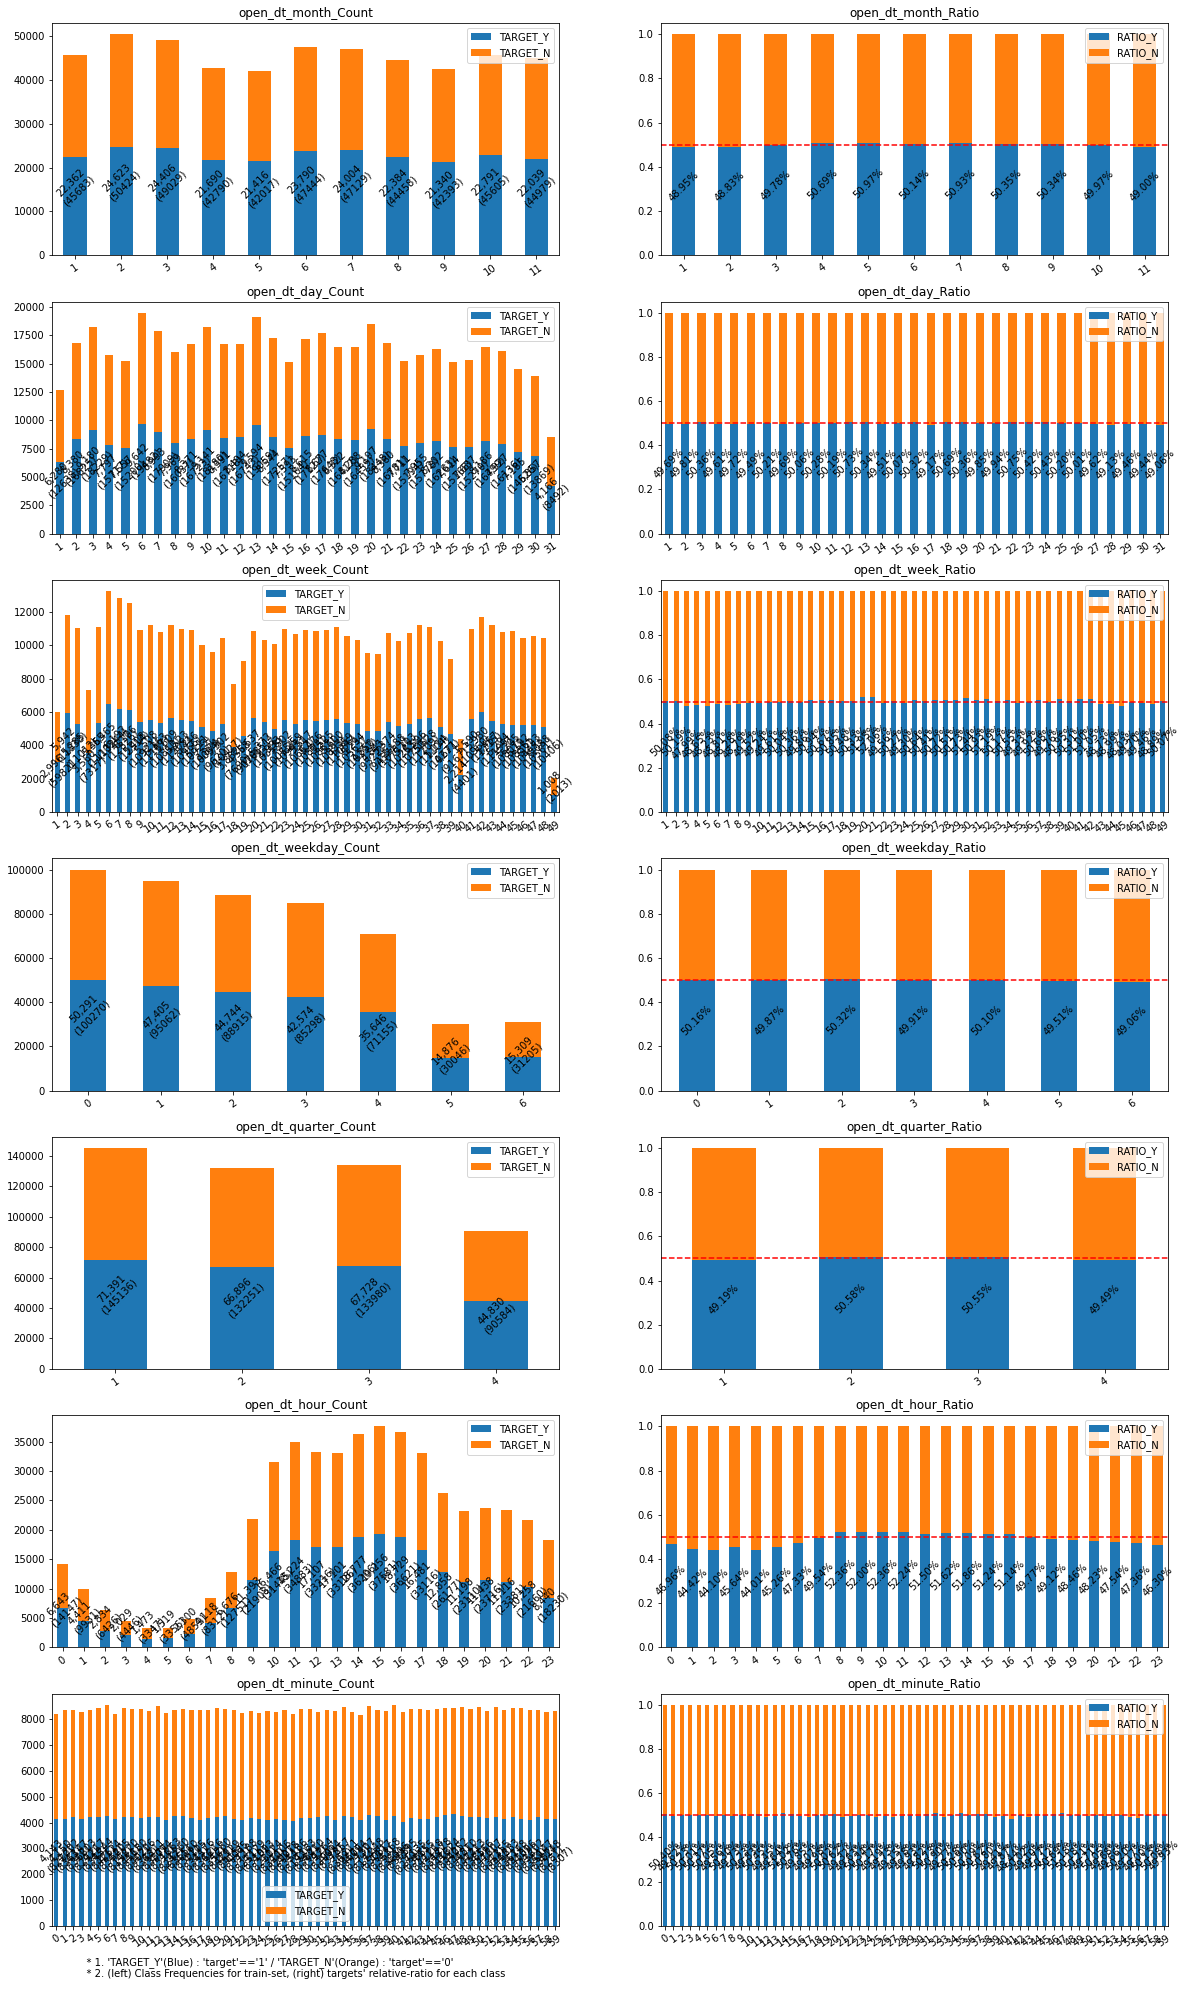

In [16]:
# * Plotting  
# ------------------------------ 
open_dt_cols = train_dt.columns[train_dt.columns.str.contains('open_dt_')] # list( column_name1, column_name2, ... )

countsWithRelativeRatio(open_dt_cols, caption=True)

* **_Train-set에서 '컨텐츠열람일시'는_**
> 1. "open_dt_month" : 컨텐츠열람-월   
>    : 월(month)에 대한 빈도 bar plot을 보면, 채용 공고가 비교적 많이 몰리는 상반기 채용시기(2월~3월)와 하반기 채용시기(6월~8월), 그리고 연말에 전체 빈도 수가 높아지는 것을 볼 수 있습니다. 이러한 계절성(Seasonality)은 'open_dt_quarter'(분기별), 'open_dt_week'(주별) 빈도 plot에도 확인됩니다. __하지만, 전체 방문자 수의 증/감과 거의 무관하게 '컨텐츠열람비율'은 (최소한 train-set 조건에서는) 꾸준하게 50%를 유지하고 있습니다.__  
> 2. "open_dt_hour" : 컨텐츠열람-시간
>    : 그나마 비율 plot에서 가장 차이를 보이는 변수는 "open_dt_hour"(시간별)입니다. "컨텐츠열람비율"은, 주 활동시간인 오전 8시부터 오후 4시 사이에 50%를 넘고, 그 외 시간에는 50%를 넘지 못하는 현상이 관측됩니다. __하지만, 여전히 상당히 근소한 차이로, 비율이 가장 높은 때와 가장 낮은 때의 차이(max - min)는 8.25%p 뿐이 되지 못합니다.__

### 2. Cardinality가 높지 않은 모든 범주형 변수에 대한 열람비율 비교 

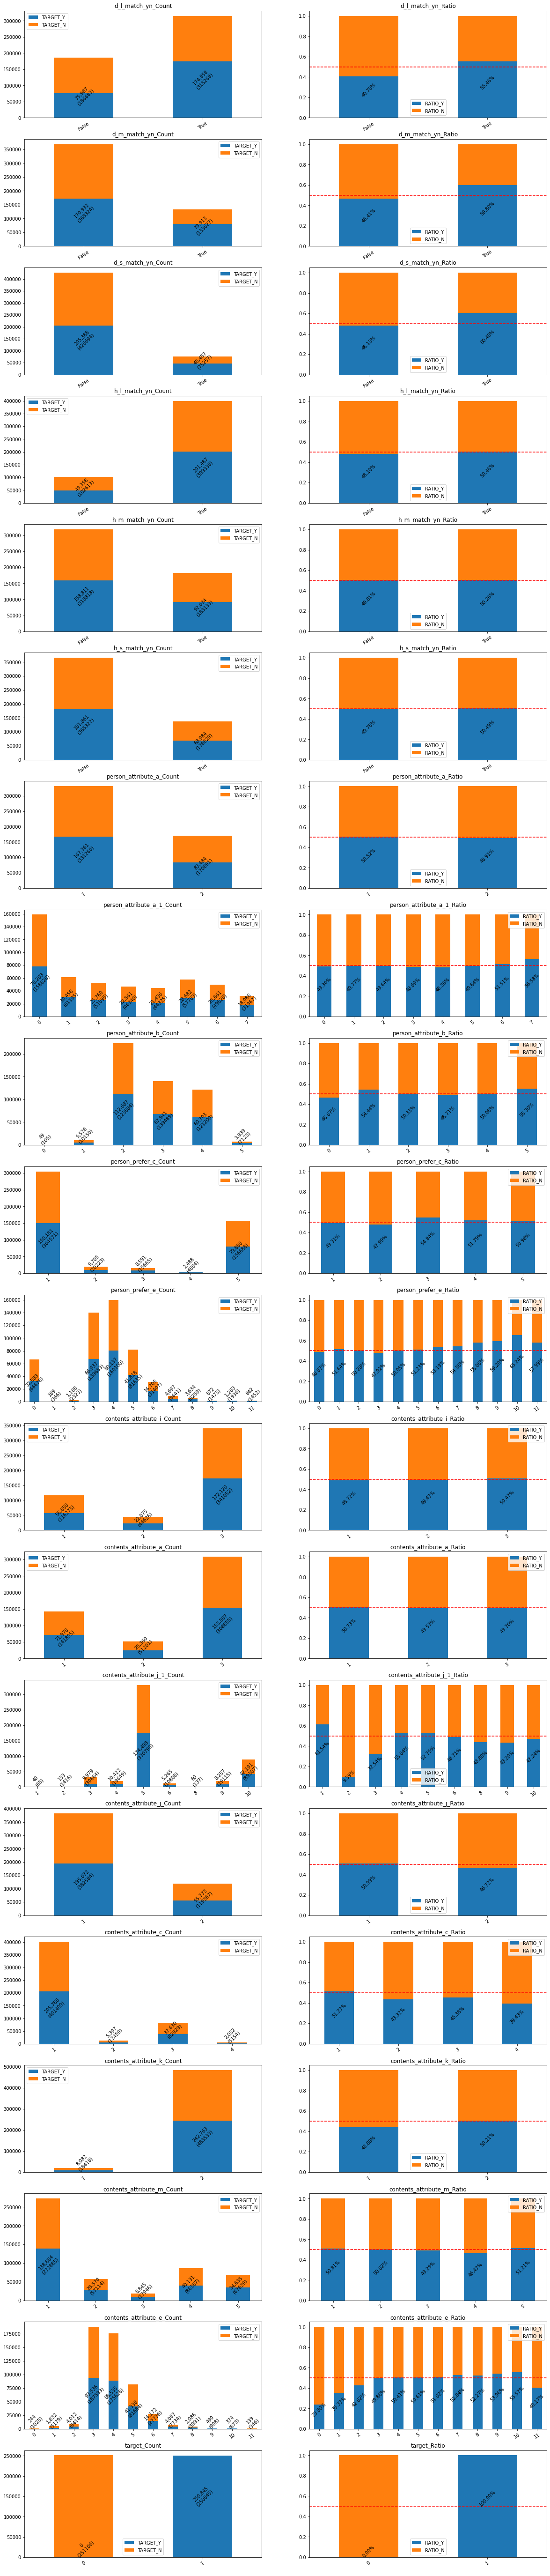

In [17]:
# Columns for Low-Cardinality 
nuniq_ = train.nunique()
LowCardinality_cols = nuniq_[nuniq_.le(20)&nuniq_.ge(2)].index

# * Plotting  
# ------------------------------ 
countsWithRelativeRatio(LowCardinality_cols)

* **_Train-set에서 'cardinality가 높지 않은 모든 컬럼들'은_**
> 1. "..\_match_yn" : 사람~컨텐츠-속성일치여부   
>    : 속성일치여부 속성은 {D, H}가 {l: Large, m: Medium, s: Small} 분류별로 제공됩니다. __'속성D'의 경우, (대 $\to$ 중 $\to$ 소)로 갈수록, 즉 더 세세한 속성까지 일치할 수록 '빈도는 더 적고, 열람 확률은 더 높은' 현상이 관찰됩니다.__ 하지만 '속성H'의 경우, 분류정도가 더 세세히 일치하는 것과 무관하게 열람 확률은 항상 절반 수준으로 유사한 것을 볼 수 있습니다. 
> 2. "attribute/prefer..." : 그 외 속성 군 
>    : 대체로, 단일 속성 하나에서 각 class별 빈도 편차는 매우 심하게 나타납니다. 이는, 실제 'person'과 'contents'의 불균형한 분포가 주된 이유로 추정되지만, 동시에 값이 기입되지 못한 경우 등에 따른 '기본 값' 세팅에 따른 빈도 편중 또한 생각해볼 수 있습니다. __즉, 하나의 컬럼 안에서 빈도가 유독 높은 class가 있다하더라도, 해당 class가 어떤 의미를 대표하지 못하는 유형일 수 있으며, 또한 '컨텐츠열람비율'에 큰 차이를 나타내지도 않은 경우가 많다__ 는 것을 주의할 필요가 있어 보입니다. 

### 3. 'person'~'contents'간 '대응 가능한 속성'의 모든 조합에 대한 열람비율 비교 

In [18]:
# * 속성 조합 시 비교 
# ---------------------------- 
# person_attribute_a & contents_attribute_a
train_dt['derivatives_a_a'] = train_dt['person_attribute_a'].astype(str) + '-' + train_dt['contents_attribute_a'].astype(str)

# person_attribute_a & person_attribute_a_1
train_dt['derivatives_person_a_a_1'] = train_dt['person_attribute_a'].astype(str) + '-' + train_dt['person_attribute_a_1'].astype(str)

# person_prefer_c & contents_attribute_c
train_dt['derivatives_c_c'] = train_dt['person_prefer_c'].astype(str) + '-' + train_dt['contents_attribute_c'].astype(str)

# contents_attribute_j & contents_attribute_j_1
train_dt['derivatives_contents_j_j_1'] = train_dt['contents_attribute_j'].astype(str) + '-' + train_dt['contents_attribute_j_1'].astype(str) 

# person_prefer_e & contents_attribute_e
train_dt['derivatives_e_diff'] = train_dt['person_prefer_e'] - train_dt['contents_attribute_e']

| 컬럼명            | 설명  |
|:------------------|:------|
|"derivatives_a_a"            | 'person' & 'contents'의 속성'a' 조합 값 |
|"derivatives_person_a_a_1"   | 'person-a' & 'person-a-1'의 속성 조합 값 |
|"derivatives_c_c"            | 'person' & 'contents'의 속성'c' 조합 값 |
|"derivatives_contents_j_j_1" | 'contents-j' & 'contents-j-1'의 속성 조합 값 |
|"derivatives_e_diff"         | 'person' & 'contents'의 속성'e' 차이 |

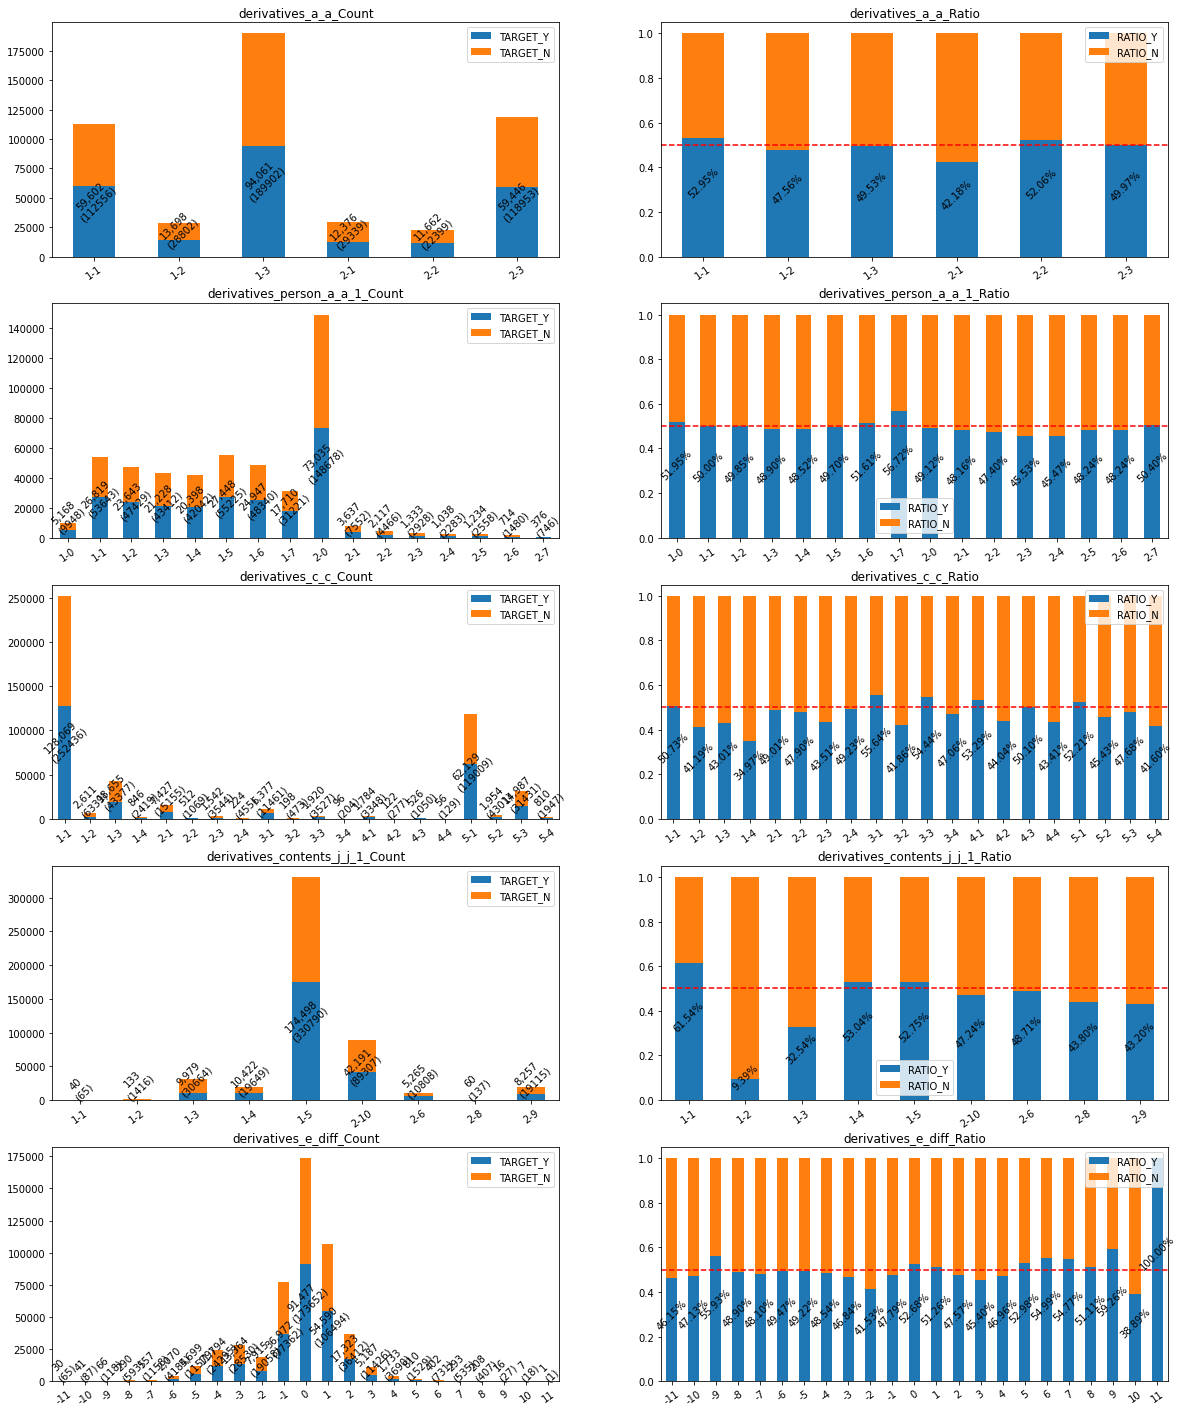

In [19]:
derivative_cols = train_dt.columns[train_dt.columns.str.contains("derivatives_")]

# * Plotting  
# ------------------------------ 
countsWithRelativeRatio(derivative_cols)

In [20]:
# * a-a 
# 절대 카운트로 보면 : 
# -> 컨텐츠 3일 때, 제일 카운트 큼, + 회원이 1, 2 일때 모두 똑같은 열람 비율 
# -> 회원 1, 2 / 컨텐츠 1, 2 사이에는 'True'/'False'가 약간의 신뢰 가능 
#   => 53% vs 47% 수준 

### 4. 속성 {D, H}의 '분류별 일치여부' 따른 열람비율 비교 

#### 4.1 '...\_yn': 대/중/소 일치여부 조합에 따른 비교 

In [21]:
# d/h_match_yn cols 
d_yn_cols = train_dt.columns[train_dt.columns.str.contains('^d_')]
h_yn_cols = train_dt.columns[train_dt.columns.str.contains('^h_')]

# T-F 조합 속성 생성 
train_dt['d_yn_comb'] = pd.concat([train_dt[yn_col_].astype(str).str[0] for yn_col_ in d_yn_cols], axis=1).T.sum()
train_dt['h_yn_comb'] = pd.concat([train_dt[yn_col_].astype(str).str[0] for yn_col_ in h_yn_cols], axis=1).T.sum()

# 모든 조합 속성 생성 
train_dt['d+h_yn_comb'] = 'D:' + train_dt['d_yn_comb'] + '/H:' + train_dt['h_yn_comb']

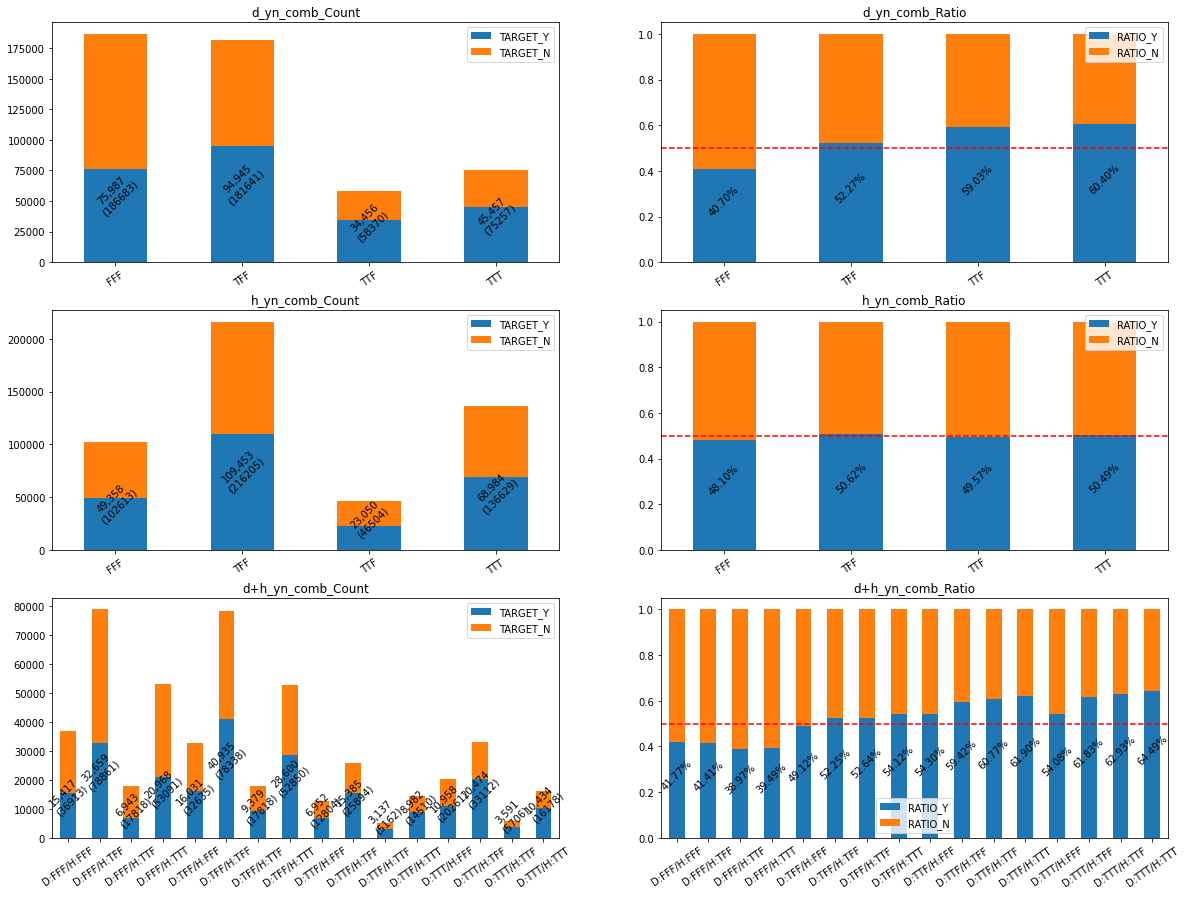

In [22]:
yn_comb_cols = train_dt.columns[train_dt.columns.str.contains("_yn_comb")]

# * Plotting  
# ------------------------------ 
countsWithRelativeRatio(yn_comb_cols)

* **_Train-set에서 'D', 'H' 속성의 일치 정도는_**
> 1. "D" / "H" : 각각 속성에 대해    
>    : __"D"의 경우, (대-중-소) 분류가 모두 일치 할 수록 '컨텐츠열람확률'이 높을 것으로 볼 수 있습니다. 반면 'H' 는 그렇지 못합니다.__ 
> 2. "D" & "H" : 두 속성의 모든 조합에 대해 
>    : __"D&H" 조합에 따른 비율로 보면, 'D&H'가 일치할 수록 더 높은 '컨텐츠열람비율'을 확인할 수 있습니다.__ 이는 단순히 'D' 하나가 모두 일치할 때보다 더 높아진 열람 확률을 보입니다. __즉, 속성간 경우의 수 조합에 따라 열람 확률이 높아질 수 있는 케이스에 해당합니다.__ 이는 Tree 기반의 알고리즘이 비교적 높은 성능을 보이는 것과 연관지어 생각해볼 수 있습니다. 

#### 4.2 '선호_1, 2, 3'의 일관성 강도: '선호 유형이 얼마나 뚜렷한가?'

In [23]:
# *feat- code handling 
feat_D = feature_D_code.astype(str).copy()
feat_H = feature_H_code.astype(str).copy()
feat_L = feature_L_code.astype(str).copy()

feat_D['D_MED'] = feat_D['D_LAG']+'-'+feat_D['D_MED']
feat_D['D_SML'] = feat_D['D_MED']+'-'+feat_D['D_SML']
feat_D['D_DET'] = feat_D['D_SML']+'-'+feat_D['D_DET']

feat_H['H_MED'] = feat_H['H_LAG']+'-'+feat_H['H_MED']

feat_L['L_MED'] = feat_L['L_LAG']+'-'+feat_L['L_MED']
feat_L['L_SML'] = feat_L['L_MED']+'-'+feat_L['L_SML']
feat_L['L_DET'] = feat_L['L_SML']+'-'+feat_L['L_DET']

In [24]:
# * Feature-'D'에 대한 '선호 강도'(: 유사도)
# ------------------------ 
pers_d_cols = train_dt.columns[train_dt.columns.str.contains('person_prefer_d')]
cat_lvs = ['D_LAG', 'D_MED', 'D_SML']

pers_d_frame = []

for cat_lv_ in cat_lvs: 

    cat_lv_mapper = {rec_[1]['D_ALL'] : rec_[1][cat_lv_] for rec_ in  feat_D[['D_ALL', cat_lv_]].iterrows()} 
    pers_d_view = train_dt[pers_d_cols].astype(str).copy()

    # 속성 - level 변환 
    pers_d_cnvt = pd.concat([pers_d_view[pers_d_col_].map(cat_lv_mapper) for pers_d_col_ in pers_d_cols], axis=1)

    # level 별 - 선호칸 별 동일 카테고리 여부  
    frames = [(pers_d_cnvt.iloc[:, lf_]==pers_d_cnvt.iloc[:, rt_]).rename(f"derivatives_{cat_lv_}_{str(lf_+1)}{str(rt_+1)}") for lf_, rt_ in [(0, 1), (0, 2), (1, 2)]]
    pers_d_lv_yn = pd.concat(frames, axis=1)

    # 유사(-강)도 수치 
    pers_d_lv_yn[f"derivatives_{cat_lv_}_sim"] = pers_d_lv_yn.sum(axis=1)
    pers_d_frame.append(pers_d_lv_yn)

deriv_d_df = pd.concat(pers_d_frame, axis=1)

deriv_d_df.head()

# 아래처럼, 각 경우의 수에 따른 일치갯수를 모두 반환합니다. 
# ex) 속성D-대분류에서 - 선호1-2 일치여부 : False, 선호1-3 일치여부 : True, 선호2-3 일치여부 : False 
# ==> 속성D-대분류-일치 강도(/유사도) : False + True + False = 1 

,derivatives_D_LAG_12,derivatives_D_LAG_13,derivatives_D_LAG_23,derivatives_D_LAG_sim,derivatives_D_MED_12,derivatives_D_MED_13,derivatives_D_MED_23,derivatives_D_MED_sim,derivatives_D_SML_12,derivatives_D_SML_13,derivatives_D_SML_23,derivatives_D_SML_sim
0,True,True,True,3,False,False,True,1,False,False,True,1
1,True,True,True,3,True,True,True,3,False,False,True,1
2,False,True,False,1,False,True,False,1,False,False,False,0
3,True,True,True,3,True,True,True,3,True,True,True,3
4,True,True,True,3,False,False,True,1,False,False,True,1


In [25]:
# * Feature-'H'에 대한 '선호 강도'(: 유사도)
# ------------------------ 
pers_d_cols = train_dt.columns[train_dt.columns.str.contains('person_prefer_h')]
cat_lvs = ['H_LAG', 'H_MED']

pers_d_frame = []

for cat_lv_ in cat_lvs: 

    cat_lv_mapper = {rec_[1]['H_ALL'] : rec_[1][cat_lv_] for rec_ in  feat_H[['H_ALL', cat_lv_]].iterrows()} 
    pers_d_view = train_dt[pers_d_cols].astype(str).copy()

    # 속성 - level 변환 
    pers_d_cnvt = pd.concat([pers_d_view[pers_d_col_].map(cat_lv_mapper) for pers_d_col_ in pers_d_cols], axis=1)

    # level 별 - 선호칸 별 동일 카테고리 여부  
    frames = [(pers_d_cnvt.iloc[:, lf_]==pers_d_cnvt.iloc[:, rt_]).rename(f"derivatives_{cat_lv_}_{str(lf_+1)}{str(rt_+1)}") for lf_, rt_ in [(0, 1), (0, 2), (1, 2)]]
    pers_d_lv_yn = pd.concat(frames, axis=1)

    # 유사(-강)도 수치 
    pers_d_lv_yn[f"derivatives_{cat_lv_}_sim"] = pers_d_lv_yn.sum(axis=1)
    pers_d_frame.append(pers_d_lv_yn)

deriv_h_df = pd.concat(pers_d_frame, axis=1)

# deriv_h_df.head()

In [26]:
# df 병합 
train_dt = pd.concat([train_dt, deriv_d_df, deriv_h_df], axis=1).copy()

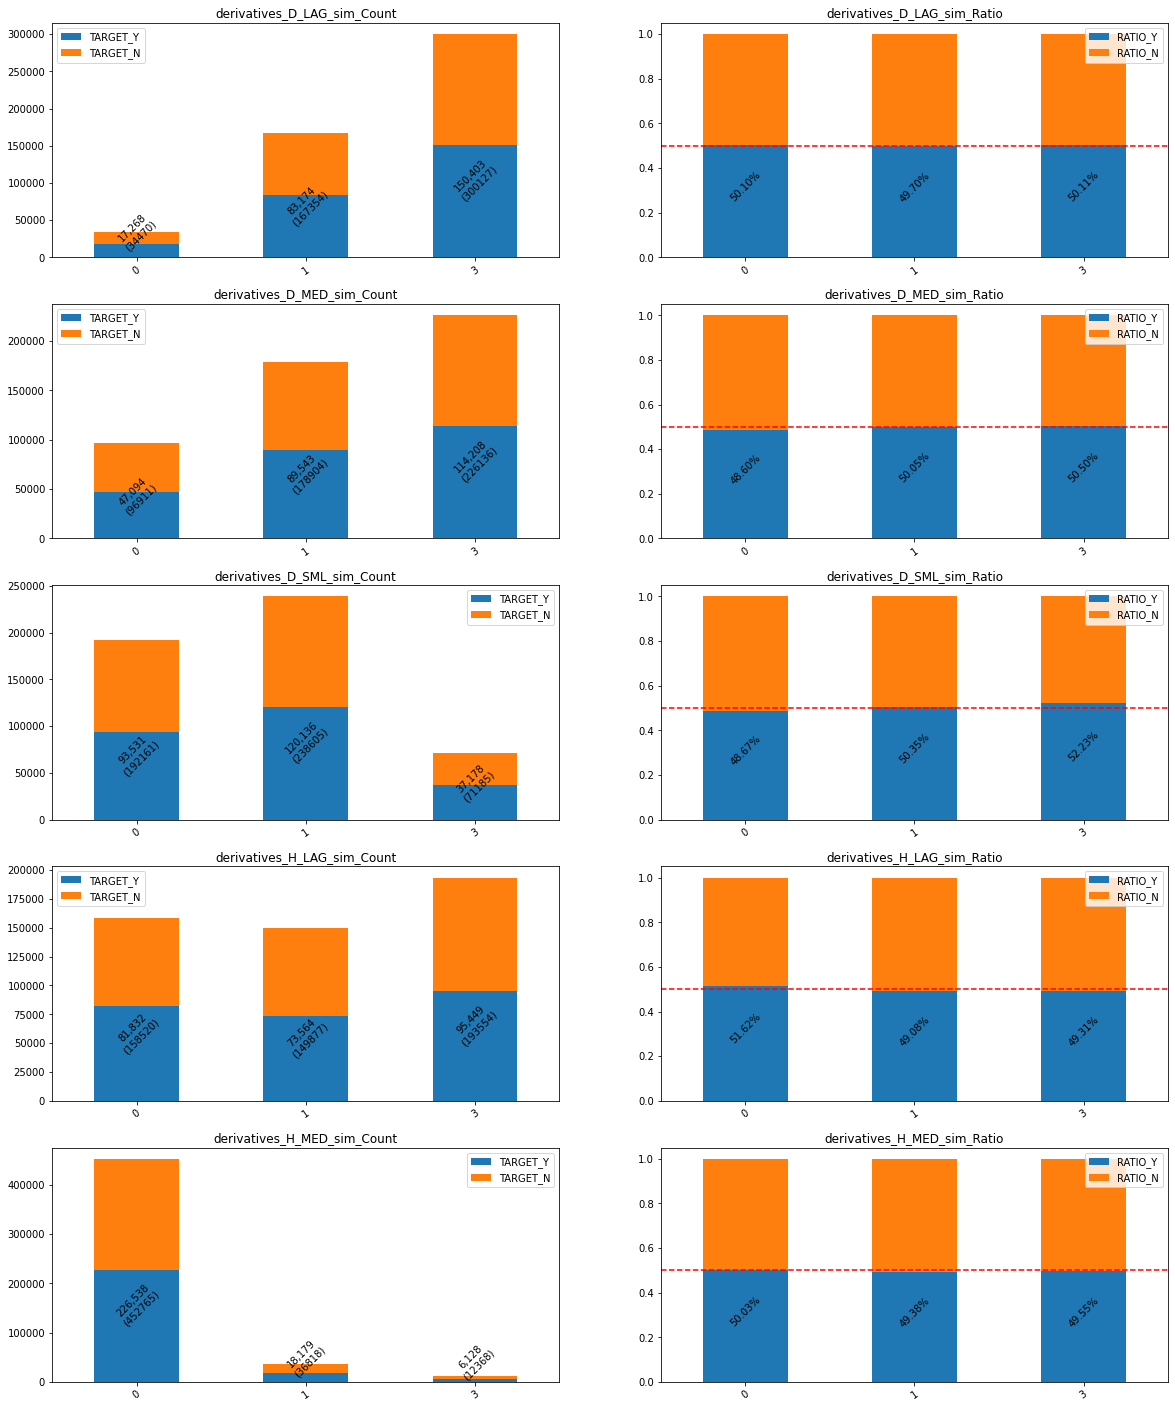

In [27]:
prefer_dh_sim_cols = train_dt.columns[train_dt.columns.str.contains('_sim')]

# * Plotting  
# ------------------------------ 
countsWithRelativeRatio(prefer_dh_sim_cols)

* **_'person'의 'D', 'H' 속성 1-2-3 일관성 강도는_**
> 1. "H" / "D" : 각각 속성에 대해    
>    : __"H", "D" 두 경우 모두, 분류에 영향력을 확인 할 수 없었습니다. 

#### 4.3  $\leftarrow$   조합( (4.1)선호 속성 컨텐츠 여부 & (4.2)속성 선호 일관성 ) 

In [28]:
# d/h_match_yn cols 
d_sim_cols = train_dt.columns[train_dt.columns.str.contains('D_..._sim', regex=True)]
h_sim_cols = train_dt.columns[train_dt.columns.str.contains('H_..._sim', regex=True)]

# T-F 조합 속성 생성 
d_yn_comb_with_sim = pd.concat([train_dt['d_yn_comb']+'_'+train_dt[d_sim_col_].astype(str) for d_sim_col_ in d_sim_cols], axis=1)
h_yn_comb_with_sim = pd.concat([train_dt['h_yn_comb']+'_'+train_dt[h_sim_col_].astype(str) for h_sim_col_ in h_sim_cols], axis=1)

d_yn_comb_with_sim.columns = d_sim_cols+'_yn_comb'
h_yn_comb_with_sim.columns = h_sim_cols+'_yn_comb'

# 모든 조합 속성 생성 
train_dt = pd.concat([train_dt, d_yn_comb_with_sim, h_yn_comb_with_sim], axis=1)

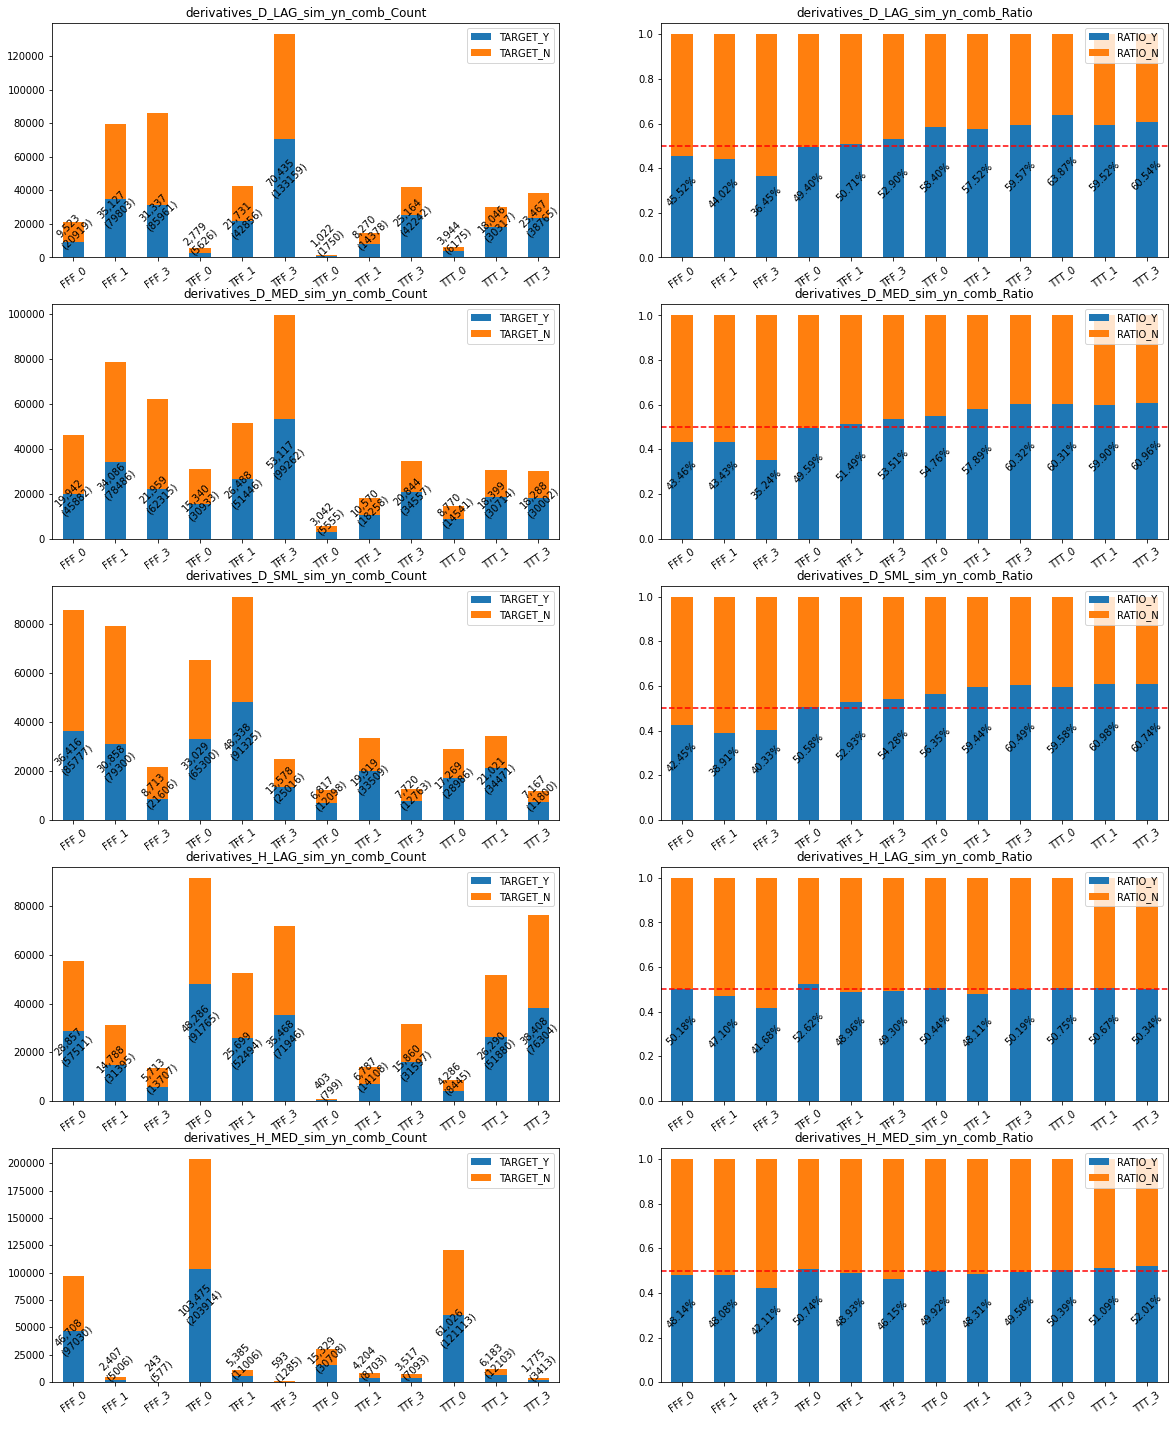

In [29]:
prefer_dh_sim_with_comb_cols = d_yn_comb_with_sim.columns.tolist() +  h_yn_comb_with_sim.columns.tolist()

# * Plotting  
# ------------------------------ 
countsWithRelativeRatio(prefer_dh_sim_with_comb_cols)

* **_'person'의 'D', 'H' 속성 1-2-3 일관성 강도는_**
> 1. 'D'에 대한 컨텐츠 세부 분류가 같을수록 + 세부 선호 강도가 셀수록 (->'TTT_3'), 전반적으로 열어보는 확률이 높은 편입니다.   
>    $\rightarrow$ ('MED', 'SML' 중에서 )
> 2. 'H'에서는 큰 차이를 확인하기 어렵습니다 